### Time Signal을 input으로 넣고 Time를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (10000, 4000)
Clean_data.shape: (10000, 4000)


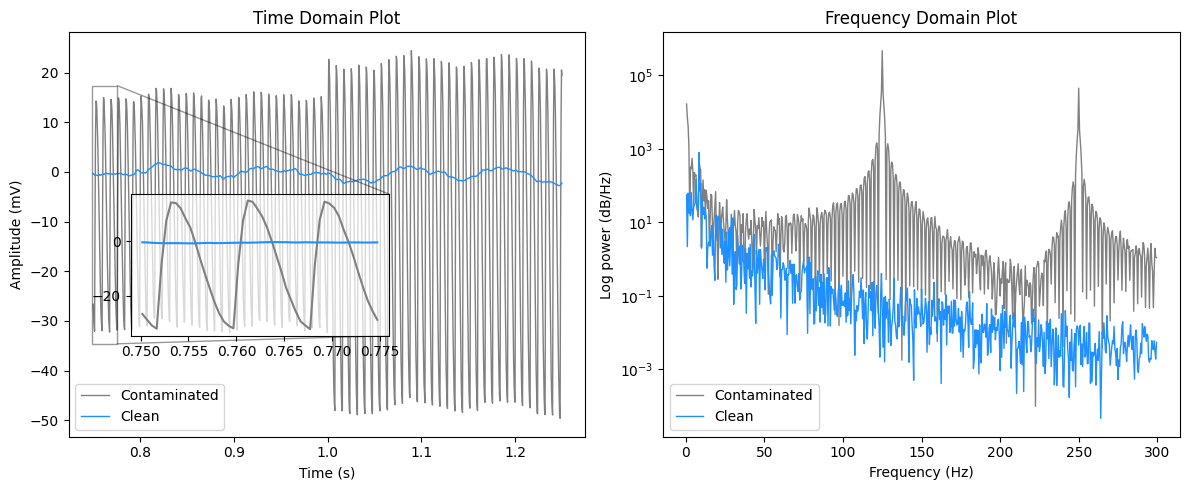

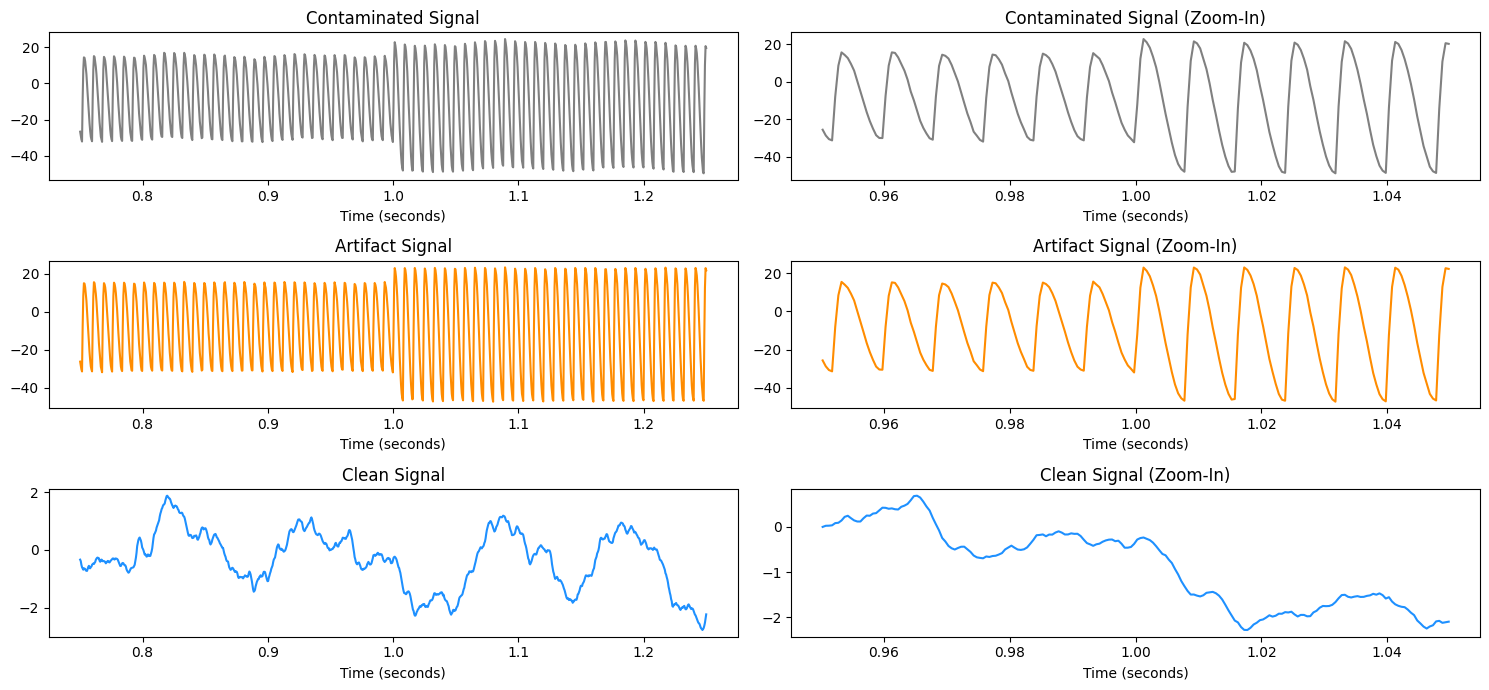

In [2]:
# 데이터 load & plot
datapath= "C:/Users/User/Desktop/SCH/10000_data/"

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (10000, 4000)
y: (10000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (8000, 4000)
y_train shape: (8000, 4000)
-----------------------------
X_test shape: (2000, 4000)
y_test shape: (2000, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (8000, 4000, 1)
y_train shape: (8000, 4000, 1)
-----------------------------
X_test shape: (2000, 4000, 1)
y_test shape: (2000, 4000, 1)
-----------------------------


In [5]:
class LSTM_Block(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Block, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)

        self.gelu = nn.GELU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        # output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)

        return out
    
class LSTM_time(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_size, hidden_size)

        self.net = nn.Sequential(*[
            LSTM_Block(hidden_size, hidden_size, 1)
            for i in range(num_layers)
        ])
        
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x): # B x T x 1
        x = self.gelu(self.dropout(self.fc1(x))) # x: B x T x 128
        x = self.net(x) # x: B x T x 128
        x = self.fc2(x) # x: B x T x 1 -> B x T
        x = self.gelu(x)

        return x

In [6]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 128  # 임의의 hidden layer 크기
output_size = 1  # 출력 크기
num_layers = 2  # 임의의 LSTM layer 개수

model = LSTM_time(input_size, hidden_size, output_size, num_layers).to(device)
print(model)
    
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

LSTM_time(
  (dropout): Dropout(p=0.1, inplace=False)
  (gelu): GELU(approximate='none')
  (relu): ReLU()
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (net): Sequential(
    (0): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
    (1): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [7]:
# 모델 학습
num_epochs = 500

loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_list.append(epoch_loss)
    if (epoch+1)%5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss}')


Epoch [5/500] | Loss: 0.00041129156202077865
Epoch [10/500] | Loss: 0.00026977313327370214
Epoch [15/500] | Loss: 0.00020813623123103753
Epoch [20/500] | Loss: 0.00017232020013034343
Epoch [25/500] | Loss: 0.00015577808720991016
Epoch [30/500] | Loss: 0.0001424915485549718
Epoch [35/500] | Loss: 0.00013518829570966772
Epoch [40/500] | Loss: 0.0001288547175063286
Epoch [45/500] | Loss: 0.00012352518999250606
Epoch [50/500] | Loss: 0.00012014497932977974
Epoch [55/500] | Loss: 0.00011669347144197673
Epoch [60/500] | Loss: 0.00011398145052953624
Epoch [65/500] | Loss: 0.00011009643328725361
Epoch [70/500] | Loss: 0.00010728530058986508
Epoch [75/500] | Loss: 0.00010422741883667186
Epoch [80/500] | Loss: 9.961821284377947e-05
Epoch [85/500] | Loss: 9.658321249298751e-05
Epoch [90/500] | Loss: 0.00010273781439173035
Epoch [95/500] | Loss: 9.981751962914132e-05
Epoch [100/500] | Loss: 9.873395212343893e-05
Epoch [105/500] | Loss: 9.753803370404058e-05
Epoch [110/500] | Loss: 9.62703283585142

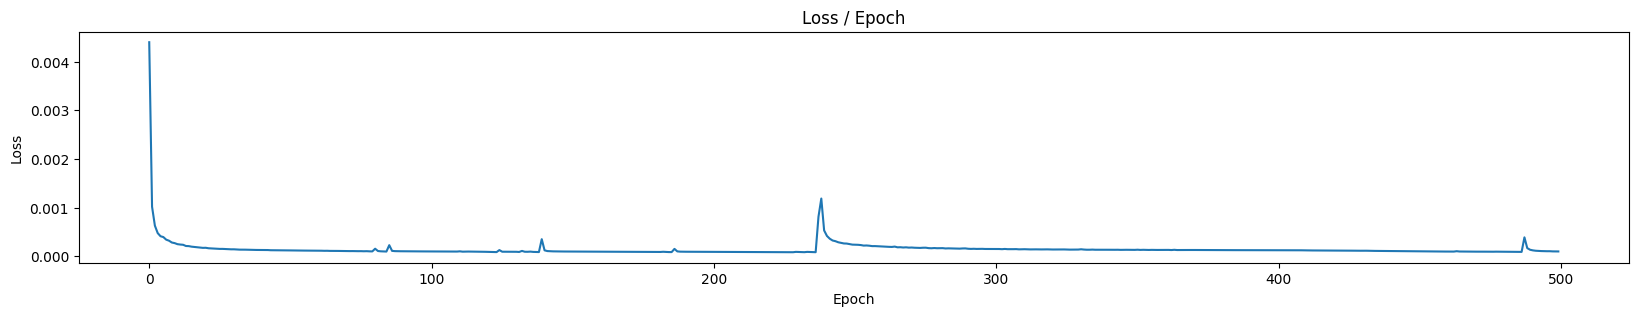

Minimal Loss: 8.272355739609338e-05 [228]



In [8]:
# Train Loss Plot
Loss_Plot(loss_list)

In [9]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss}')

Test Loss: 0.00031347813084721567


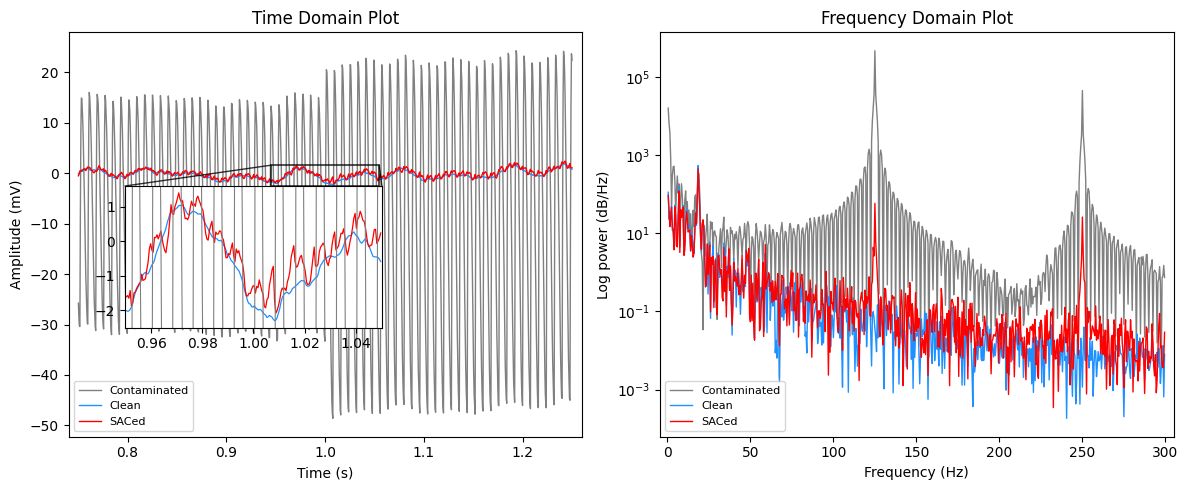

< MSE >
Time Domain MSE: 0.11493674238216509 ± 0.02246575516589659
Frequency Domain MSE: 45.869484729202235 ± 22.456792870603742
Time + Frequency MSE: 19.147609838541715 ± 2.7684886078584396


In [10]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
save_path = '../../../../result/data_10000/LSTM/'
save_title = 'LSTM_IO_time_L_time'

Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled, save_path, save_title) # inverse scaled data를 input으로 넣음